## Geologic model of Gottesacker from scratch in GemPy
***
**Files needed**
<br>- interfaces.csv - must have at least 2 pts per unit, column headings (case-sensitive): X, Y, Z, formation. XYZ must be numbers not strings, for pt coordinates. formation is the formation name string.
<br>- orientations.csv - must have at least 1 pt per unit, column headings (case-sensitive): X, Y, Z, azimuth, dip, polarity, formation. azimuth=strike in degrees east of north, polarity=1
<br>- DEMraster.tif - digital elevation model raster file

***
**To-do:**
<br>- figure out how to efficiently get points from a geologic map
<br> --> enable interactive point picking using bokeh (or matplotlib?) - set formation first, then pick points interactively and append them to the dataframe for that formation, then run function again for each formation
<br>- add ability to create points by adding or subtracting a formation's thickness from a point on the overlying or underlying formation?
<br>- add x-sections - how to do this? georeference the lines in ArcMap? then what?
<br>- fix topography slicing to get geologic map for cross-checking

<br>*IMPORTANT:* Nico's geologic map has x coordinates that have an extra '3' at the beginning. This has to be removed in order to get normal UTM coordinates. Why?


## Imports & Setup

In [4]:
# Import packages:

import sys, os
import numpy as np
import pandas as pn
import matplotlib.pyplot as plt
import theano
import geopandas as geo
import gdal
from copy import copy


sys.path.append("../../..")   #optional: if gempy has been downloaded from GitHub rather than installed normally, look for it in the folders above the current folder
import gempy as gp

# Import local packages:
import elisa

#embed matplotlib figures into notebooks:
%matplotlib inline            

../../..\gempy\plotting\visualization.py:36: UserWarning: Steno 3D package is not installed. No 3D online visualization available.
  warnings.warn('Steno 3D package is not installed. No 3D online visualization available.')
../../..\gempy\posterior_analysis.py:24: UserWarning: pymc (v2) package is not installed. No support for stochastic simulation posterior analysis.
  warnings.warn("pymc (v2) package is not installed. No support for stochastic simulation posterior analysis.")
../../..\gempy\posterior_analysis.py:28: UserWarning: pymc (v3) package is not installed. No support for stochastic simulation posterior analysis.
  warnings.warn("pymc (v3) package is not installed. No support for stochastic simulation posterior analysis.")


Raster dimensions: 
xmin: 574987.5 		xmax: 594037.5 		xres: 381 
ymin: 5237962.5 	ymax: 5253012.5 	yres: 301 
zmin: 791.0 		zmax: 2381.0 		zres: na


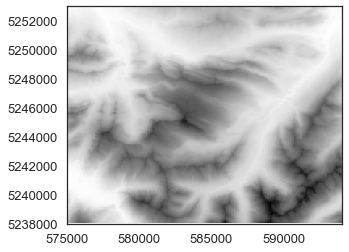

In [23]:
def importDEM(filename, show=True):
    '''Import DEM from a tif file using gdal package.
    Return a dem object, and xyz extent and resolution.
    (this can be used to set the model extent)
    NOTE: vertical (z) resolution can't be extracted from the raster!
    
    filename: string indicating the filename (must be a rectangular tif)
    show:     option to show a plot of the DEM or not.
    
    xmin:     minimum x value (same for ymin, zmin)
    xmax:     maximum x value (same for ymax, zmax)
    xres:     x resolution, aka number of columns, aka number of cells along x axis (NOT pixel width)
    etc.
    '''
    
    dem = gdal.Open(filename)    #DEM must be rectangular tif 
    dema = dem.ReadAsArray()     #copy of DEM as a numpy array

    ulx, pixelwidthx, xskew, uly, yskew, pixelheighty = dem.GetGeoTransform() #get resolution and coordinate info (for some reason the order of skew and pixel size is flipped for y axis?!)
    ncol = dem.RasterXSize  #number of columns (aka number of cells along x axis)
    nrow = dem.RasterYSize  #number of rows (aka number of cells along y axis)
    lrx = ulx + (ncol * pixelwidthx)  #lower right x coord = upper left x coord + (width of raster cells in x direction * number of raster cells in x direction)
    lry = uly + (nrow * pixelheighty)

    #Get min and max elevations (z):
    srcband = dem.GetRasterBand(1)        #get the first band (with the elevation data)
    zmin,zmax,zmean,zstdv = srcband.GetStatistics(True, True)  #get stats for this band (this will automatically ignore the nan value I think)               

    #Assign useful names:
    xmin = ulx
    xmax = lrx
    xres = ncol
    ymin = lry
    ymax = uly
    yres = nrow
    zres = 'na'     #can't be extracted from raster

    #Print results & display raster:
    if show==True:
        print('Raster dimensions: \nxmin: {} \t\txmax: {} \t\txres: {} \nymin: {} \tymax: {} \tyres: {} \nzmin: {} \t\tzmax: {} \t\tzres: {}'.format(xmin,xmax,xres,ymin,ymax,yres,zmin,zmax,zres))
        plt.imshow(dema, extent=(xmin,xmax,ymin,ymax), vmin=zmin, vmax=zmax) #plot raster as image
        #print(gdal.Info(dem))  #for more detailed file info, uncomment this line
        
    return dem,xmin,xmax,xres,ymin,ymax,yres,zmin,zmax,zres

dem,xmin,xmax,xres,ymin,ymax,yres,zmin,zmax,zres = importDEM('DEMraster50.tif',show=True)        
zres = 100   #manually choose a zres to use for model

In [24]:
#GK files are hand-picked data from Nico's map (and don't have a fault)
#gottesacker files are quick-picked data with DEM (and have a fault)
#geo_dat resolution does NOT have to match DEM resolution, but it helps later for map?
#lower resolution computes much faster
geo_data = gp.InputData([xmin,xmax, ymin,ymax, zmin,zmax], [xres//2,yres//2,zres],      #set x,y,z min and max extent, and x,y,z resolution (can use info from DEM but must be integers)
                       path_i='GK_interfaces_ArcMap_clean_sd_only.csv',         #csv file for interface points: must be at bottom of a layer, col names are case sensitive, must include at least 2 points per unit
                       path_o='GK_orientations_ArcMap_clean.csv')       #csv file for orientation points: col names are case sensitive, must include at least one point per unit 

In [25]:
# View geologic info:
print(gp.get_data(geo_data, itype='formations'))   #list formations
geo_data.interfaces.head()                  #display first few rows of geo_data dataframe
#gp.plot_data(geo_data)                      #plot geo_data
#gp.plot_data_3D(geo_data)                  #plot geo_data in 3D using VTK (optional) (note: when a VTK interactive window is open, nothing else in the notebook can run - pause or close the window before continuing)

            value  formation_number
Amdener         1                 1
Drusberg        2                 2
Garschella      3                 3
Quaternary      4                 4
basement        5                 5


,X,Y,Z,formation,series,formation_number,order_series,isFault,annotations,formation_value
0,587196.0,5244570.0,1195.0,Amdener,Default series,1,1,False,"${\bf{x}}_{\alpha \,{\bf{1}},0}$",1
2,588506.0,5246260.0,1051.0,Amdener,Default series,1,1,False,"${\bf{x}}_{\alpha \,{\bf{1}},1}$",1
3,588328.0,5247190.0,1183.0,Amdener,Default series,1,1,False,"${\bf{x}}_{\alpha \,{\bf{1}},2}$",1
4,583886.0,5247070.0,1829.0,Amdener,Default series,1,1,False,"${\bf{x}}_{\alpha \,{\bf{1}},3}$",1
5,584993.0,5248080.0,1759.0,Amdener,Default series,1,1,False,"${\bf{x}}_{\alpha \,{\bf{1}},4}$",1


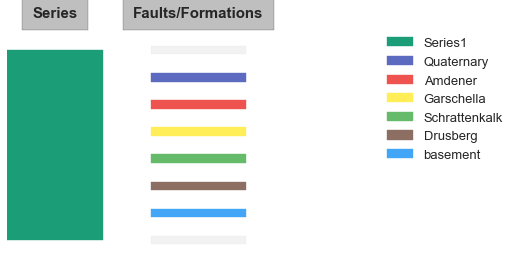

In [26]:
#Set series and formations stratigraphy for viewing:
#to-do: see how hard it would be to make colors customizable

#if using gottesacker files:
#gp.set_series(geo_data, {'Fault1': 'fault',  'Rest': ['Garschella', 'Schrattenkalk', 'Drusberg']}, verbose=1)  #series indicate BOTTOM of named layer

#if using GK files:
gp.set_series(geo_data, {'Series1': ['Quaternary','Amdener', 'Garschella', 'Schrattenkalk', 'Drusberg']}, verbose=1)  #series indicate BOTTOM of named layer


## Create model

In [27]:
# Interpolate data:
#Caution: takes a while because has to compile. 
#only have to compile once UNLESS change presence of faults or not (number of faults doesn't matter - can change the number of fms & faults afterwards)
#but have to compile after data is imported 
#if changes are made to geo_data after this step, use update_interpolator (see below)
#do you need to recompile if the resolution is changed?
#defaults to float32 - use dtype='float64' to add precision (slower)
#common problems: list of formations doesn't match formations in data files, don't have minimum required points per formation


interp_data = gp.InterpolatorData(geo_data, compile_theano=True,
                                  theano_optimizer='fast_compile', is_lith=True, is_fault=False)


Compiling theano function...
Compilation Done!
Level of Optimization:  fast_compile
Device:  cpu
Precision:  float32
Number of faults:  0


In [10]:
# Optional: if changes are made to geo_data, can update interpolation without re-compiling:
interp_data.update_interpolator(geo_data)    

In [28]:
# Compute model: 
is_fault = False        #set whether fault is present

if is_fault == False:   #if no fault
    lith = gp.compute_model(interp_data)  #lith is two arrays (each with dim: model extent) with a formation number assigned to each cell, and the orientation of that formation at each cell
    #note: format of lith seems to change if fault is present or not, so may need to index differently to get the right slice
if is_fault == True:   #if there is a fault
    # Optional: set faults to be finite:
    inf_factor = interp_data.interpolator.tg.inf_factor.get_value()     #fault extent is controlled by an infinity factor (default=10, which is larger than model scale)
    inf_factor[0]=0                                                     #set infinity factor to 0 to make faults finite
    interp_data.interpolator.tg.inf_factor.set_value(np.zeros(10, dtype="int32"))   #update value 
    interp_data.interpolator.tg.inf_factor.get_value()                              #display new values
    lith, fault = gp.compute_model(interp_data)

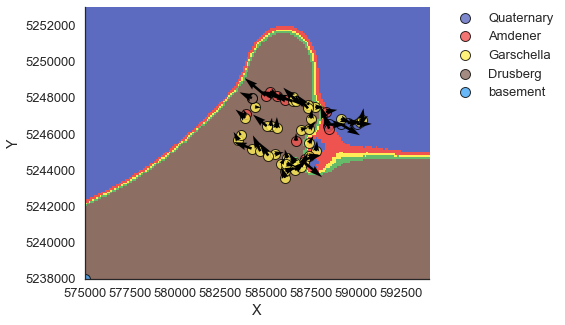

In [29]:
# Display model results:
gp.plotting.plot_section(geo_data, lith[0][0], 25, plot_data=True, direction='z')   #plot 2D x-sec (block must equal an array of formation numbers)
#ver, sim = gp.get_surfaces(interp_data, lith[0][1])                       #create 3D objects for plotting
#gp.plotting.plot_surfaces_3D_real_time(geo_data, interp_data, ver, sim)          #display in 3D with VTK
#note: this will leave this code block hanging - need to close or pause the VTK window to continue

## Project and crop with topography

to-do - use elisa's code as starting point

In [ ]:
#import DEM if not already imported:
dem,xmin,xmax,xres,ymin,ymax,yres,zmin,zmax,zres = importDEM('DEMraster50.tif',show=True)        


In [16]:
#check that DEM extent matches model extent & crop if not:
dem_extent = [xmin,xmax,ymin,ymax,zmin,zmax]       #from gdal import above (make this into a function later)
extent_mismatch = geo_data.extent - dem_extent     #find difference between model extent and dem extent

if np.any(extent_mismatch) != 0:                   #if difference is not zero at any point
    print('DEM extent does not match model extent. Need to crop.')
    warp_options = gdal.WarpOptions(options=['outputBounds'], outputBounds=(geo_data.extent[0], geo_data.extent[2], geo_data.extent[1], geo_data.extent[3])) #set desired new bounds for DEM
    gdal.Warp('DEMraster_warp.tif', dem, options=warp_options) #crop DEM to match model extent
    

In [32]:
#Reshaping:
print(np.shape(lith[0][0]))
print(geo_data.resolution)
#lb = lith[0].reshape(geo_data.resolution) 

(2850000,)
[190 150 100]
